In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import plotly.graph_objects as go
from datetime import datetime, timedelta

,date,open,high,low,close,vol
0,2012-06-19 17:30:00,11.150000,11.746667,11.091667,11.638333,23491488
1,2012-06-20 17:30:00,11.580000,11.591650,11.268333,11.359833,22636368
2,2012-06-21 17:30:00,11.376667,11.406667,10.958333,10.973333,14863914
3,2012-06-22 17:30:00,11.040000,11.378333,10.950000,11.310000,13866198
4,2012-06-25 17:30:00,11.301667,11.588333,11.066667,11.171667,25099830


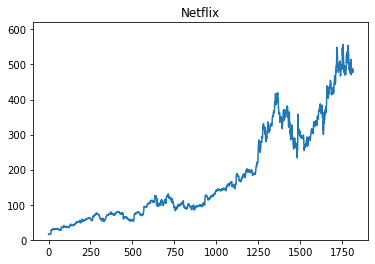

In [45]:
ticker = 'NFLX'
filename = 'resources/NFLX/NFLX-day.parquet'
data = pd.read_parquet(filename)

def add_date_column(data):
    dates = pd.DataFrame(data.index.values, columns=['date'])
    size = len(data)
    data.index = np.arange(0, size, 1)
    return dates.join(data)


def handle_splits(data):
    def perform_split(coef, to_index):
        data.loc[:to_index, 'open'] /= coef
        data.loc[:to_index, 'high'] /= coef
        data.loc[:to_index, 'low'] /= coef
        data.loc[:to_index, 'close'] /= coef
        data.loc[:to_index, 'vol'] *= coef

    n = len(data)
    for i in range(1, n):
        prev = data.iloc[i - 1]
        cur = data.iloc[i]
        split_coef = int(round(prev['close'] / cur['open']))
        if split_coef > 1:
            perform_split(split_coef, i)
    return data


def plot_data(data):
    X = np.arange(0, len(data), 1)
    plt.plot(X, data['close'].values)


data = add_date_column(data)
plot_data(data)
data.head()

,date,open,high,low,close,vol
0,2011-07-15 16:30:00,14.1700,14.17,14.135,14.1350,69653
1,2011-07-15 16:31:00,14.1350,14.16,14.110,14.1184,62534
2,2011-07-15 16:32:00,14.1200,14.16,14.120,14.1600,92077
3,2011-07-15 16:33:00,14.1600,14.16,14.120,14.1250,103168
4,2011-07-15 16:34:00,14.1298,14.13,14.090,14.0900,113788


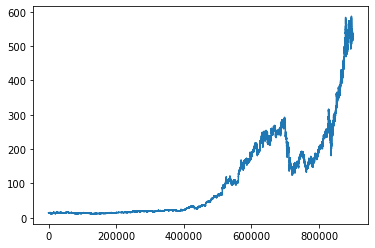

In [5]:
data = handle_splits(data)
plot_data(data)
data.head()

In [6]:
data.to_parquet(f'resources/{ticker}/{ticker}-1min.parquet')

In [7]:
def compress_candles(data, interval_type):
    def find_open(candles):
        return candles[0]['open']

    def find_close(candles):
        return candles[len(candles) - 1]['close']

    def find_low(candles):
        res = candles[0]['low']
        for cur in candles:
            if cur['low'] < res:
                res = cur['low']
        return res

    def find_high(candles):
        res = candles[0]['high']
        for cur in candles:
            if cur['high'] > res:
                res = cur['high']
        return res

    def find_vol(candles):
        res = 0
        for cur in candles:
            res += cur['vol']
        return res

    if interval_type == '5min':
        interval = timedelta(minutes=5)
    elif interval_type == '10min':
        interval = timedelta(minutes=10)
    elif interval_type == '15min':
        interval = timedelta(minutes=15)
    elif interval_type == '30min':
        interval = timedelta(minutes=30)
    elif interval_type == 'hour':
        interval = timedelta(hours=1)
    elif interval_type == '2hour':
        interval = timedelta(hours=2)
    elif interval_type == '4hour':
        interval = timedelta(hours=4)
    elif interval_type == 'day':
        interval = timedelta(days=1)
    else: raise ValueError(f'Not found interval type: {interval_type}')

    new_candles = []
    cur_time = data.iloc[0]['date']
    cur_candles = []
    for ind, candle in data.iterrows():
        if cur_time <= candle['date'] < cur_time + interval:
            cur_candles.append(candle)
        else:
            new_candles.append([cur_time, find_open(cur_candles), find_high(cur_candles),
                                find_low(cur_candles), find_close(cur_candles), find_vol(cur_candles)])
            cur_time = candle['date']
            cur_candles = [candle]
    return pd.DataFrame(new_candles, columns=['date', 'open', 'high', 'low', 'close', 'vol'])

In [8]:
intervals = ['5min', '10min', '15min', '30min', 'hour', '2hour', '4hour', 'day']
for interval in intervals:
    compressed_data = compress_candles(data, interval)
    compressed_data.to_parquet(f"resources/{ticker}/{ticker}-{interval}.parquet")

In [9]:
# def split_by_days(data):
#     n = len(data)
#     first = data.iloc[0]['date']
#     cur_time = datetime(first.year, first.month, first.day)
#     last = data.iloc[n - 1]['date']
#     end_time = datetime(last.year, last.month, last.day)
#     days = []
#     values = []
#     while cur_time <= end_time:
#         cur_values = data[(data['date'] > cur_time) & (data['date'] < cur_time + timedelta(days=1))]
#         if len(cur_values) > 0:
#             days.append(cur_time)
#             values.append(cur_values)
#         cur_time += timedelta(days = 1)
#     return np.array(days), np.array(values)
#
# days, day_candles = split_by_days(data_5min)

In [10]:
# def plot_candles(candles):
#     fig = go.Figure(data=[go.Candlestick(x=candles['date'], open=candles['open'], high=candles['high'],
#                                          low=candles['low'], close=candles['close'])],
#                     layout=go.Layout(height=600, width=1000))
#     fig.show()
#
# plot_candles(data_5min[0])
